In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import random
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt

import networkx as nx
import netwulf as nw
from netwulf import visualize
from pyvis.network import Network
import community.community_louvain


import pandas as pd
import numpy as np
import datetime as dt
import math
import pickle 
import ast
from itertools import combinations

In [3]:
all_tweets = pd.read_csv("ALL_CLEAN_TWEETS.csv")
all_tweets = all_tweets.iloc[: , 3:]
all_tweets.translated_hashtags = all_tweets.translated_hashtags.apply(ast.literal_eval)
all_tweets.tokenized_text_stemmed = all_tweets.tokenized_text_stemmed.apply(ast.literal_eval)
all_tweets.tokenized_text = all_tweets.tokenized_text.apply(ast.literal_eval)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1) Creating Twitter Graphs based on Language

In [38]:
#creating an undirected graph from a weighted edgelist based on user 
# and parent author and their original language.

def create_nx_graph(language,w_edgelist):
    G = nx.DiGraph()
    for index, value in w_edgelist.items():
        G.add_weighted_edges_from([(index[0],index[1],value)]) 
    H = G.to_undirected(reciprocal=False)
    H.remove_edges_from(list(nx.selfloop_edges(H)))
    H.remove_nodes_from(list(nx.isolates(H)))
    return G,H

In [27]:
def create_nx_undigraph(language,w_edgelist):
    G = nx.DiGraph()
    for index, value in w_edgelist.items():
        G.add_weighted_edges_from([(index[0],index[1],value)]) 
    H = G.to_undirected(reciprocal=False)
    H.remove_edges_from(list(nx.selfloop_edges(H)))
    H.remove_nodes_from(list(nx.isolates(H)))
    
    return H

In [4]:
def create_w_edgelist(df, language):
    w_edgelist = df.loc[df["language"]==language].groupby(["username", "parent_author"]).size()
    return w_edgelist 

In [39]:
#creating network graphs based on the ukrainian and russian discourse:


w_edgelist_uk = create_w_edgelist(all_tweets, "uk")
G_uk, H_uk = create_nx_graph("uk", w_edgelist_uk)

w_edgelist_ru = create_w_edgelist(all_tweets,"ru")
G_ru, H_ru = create_nx_graph("ru", w_edgelist_ru)




In [ ]:

print(nx.info(H_uk),"\n")

print(nx.info(H_ru),"\n")


## 2) Random networks as Null Models
Now we will create Random Networks as null models to investigate some properties of the three Twitter Networks.

We will create random networks based on the **R(N, p)** model introduced by Edgar Nelson Gilbert: Each pair of *N* labeled nodes is connected with probability *p*. Computing N and p from the network we are investigating is done by the following:

The formula for the for the expected number of edges in the random network is:
$$
\langle L\rangle=\sum_{L=0}^{\frac{N(N-1)}{2}} L p_{L}=p \frac{N(N-1)}{2}
$$

Setting $\langle L\rangle$ equal to the actual number of edges in the redditor network, the probabily p can be found by:
$$
p = \frac{\langle L\rangle}{\frac{N(N-1)}{2}}
$$

Next, the average value of degree is computed by:
$$
\langle k \rangle = \frac{2L}{N} = p (N-1)
$$



In [7]:
def create_random_network(H):
    L_edges = len(H.edges())
    N_nodes = len(H.nodes())
    p = L_edges/(N_nodes * (N_nodes-1)/2)
    
    R = nx.Graph()
    all_edge_combinations = list(combinations(range(N_nodes), 2))
    
    for edge in all_edge_combinations:
        if random.random() < p:
            R.add_edge(*edge)
    return R
    

In [41]:
R_uk = create_random_network(H_uk)
R_ru = create_random_network(H_ru)

In [42]:
print(nx.info(H_uk),"\n")
print(nx.info(R_uk))

Name: 
Type: Graph
Number of nodes: 3348
Number of edges: 2930
Average degree:   1.7503 

Name: 
Type: Graph
Number of nodes: 2793
Number of edges: 3020
Average degree:   2.1625


In [43]:
print(nx.info(H_ru),"\n")
print(nx.info(R_ru))

Name: 
Type: Graph
Number of nodes: 8544
Number of edges: 8132
Average degree:   1.9036 

Name: 
Type: Graph
Number of nodes: 7274
Number of edges: 8135
Average degree:   2.2367


In [21]:
top5_in_uk = sorted(G_uk.in_degree, key=lambda x: x[1], reverse=True)[:5]
for author, val in top5_in_uk:
    print(author)
    print("in degree:", val, 
          "\n")

ng_ukraine
in degree: 128 

mil_in_ua
in degree: 125 

UKRINFORM
in degree: 54 

USEmbassyKyiv
in degree: 53 

Pontifex
in degree: 47 



In [23]:
top5_in_ru = sorted(G_ru.in_degree, key=lambda x: x[1], reverse=True)[:5]
for author, val in top5_in_ru:
    print(author)
    print("in degree:", val, 
          "\n")

dw_russian
in degree: 186 

RT_russian
in degree: 101 

i_army_org
in degree: 92 

rianru
in degree: 90 

antiputler_news
in degree: 88 



### 2.1) Clustering: Compare the clustering coefficient in the Networks and their random counterpart

In [13]:
#computing the clustering coefficient for each node in the random network:

def compute_cluster_coeff(G):
    cluster_coefs = []

    for node in list(G.nodes()):
        if len(list(G.neighbors(node))) == 1:      #clustering coefficient is 0 if the node only has one neighbor
            cluster_coefs.append(0)
        else: 
            L_i = 0
            neighbors = list(combinations(list(G.neighbors(node)), 2))
            for pair in neighbors:
                if G.has_edge(*pair):
                    L_i+=1

            k_i = G.degree(node)
            cluster_coefs.append(2*L_i/(k_i*(k_i-1)+1e-5)) #add small number to avoid division by zero
    return np.mean(cluster_coefs)

In [56]:
H_uk_cc = compute_cluster_coeff(H_uk)
R_uk_cc = compute_cluster_coeff(R_uk)

In [58]:
H_ru_cc = compute_cluster_coeff(H_ru)
R_ru_cc = compute_cluster_coeff(R_ru)

In [60]:
print("Cluster coefficient for the Russian Twitter Networks:\n")
print("Original network, H_ru", round(H_ru_cc,6))
print("Random network, R_ru:", round(R_ru_cc,6))

Cluster coefficient for the Russian Twitter Networks:

Original network, H_ru 0.000344
Random network, R_ru: 0.00044


In [61]:
print("Cluster coefficient for the Ukrainian Twitter Networks:\n")
print("Original network, H_uk", round(H_uk_cc,6))
print("Random network, R_uk:", round(R_uk_cc,6))

Cluster coefficient for the Ukrainian Twitter Networks:

Original network, H_uk 0.000158
Random network, R_uk: 0.000442


In [159]:
all_tweets.loc[all_tweets.language == "uk"].tweet_type.value_counts()/len(all_tweets.loc[all_tweets.language == "uk"])

retweet     0.785794
original    0.150758
reply       0.063448
Name: tweet_type, dtype: float64

In [160]:
all_tweets.loc[all_tweets.language == "ru"].tweet_type.value_counts()/len(all_tweets.loc[all_tweets.language == "ru"])

retweet     0.709740
original    0.177193
reply       0.113067
Name: tweet_type, dtype: float64

## 3) Investigating Communities in the Twitter Networks

### 3.1) Modularity

We can investigate the communities in the Twitter Networks by computing the modularity values, which helps us measure how well a certain partition is at detecting communities. The higher these values are, the communities created are much stronger. This is because the *observed* number of links between nodes in the community is higher than the *expected* number of links, and we can infer that a certain cluster structure must be present. 

The modularity is a number between $[-1,1]$ - a value close to 1 indicates a strong partitioning and if we assign the whole network to a single community, the modularity value becomes 0 and a negative modularity value occurs for instance when we assign each node to a their own individual community. 

Computing the modularity of several partition allows us to compare them with eachother and optimizing this modularity value helps us to detect even stronger communities. 

Based on equation 9.12 in XX book, the formula for modularity is:
$$
M=\sum_{c=1}^{n_{c}}\left[\frac{L_{c}}{L}-\left(\frac{k_{c}}{2 L}\right)^{2}\right]
$$

where $n_c$ is the number of communities in the partition, $N_c$ and $L_c$ is the number of nodes and edges respectively in each of the $n_c$ communities. Furthermore, $k_c$ is the total degree of nodes in in a community $C_c$ and L is the number of links in the entire graph. We formulate this in the following function:

In [62]:
def compute_modularity(graph, partition):
   
    communities = list(set(partition.values()))  
    L = graph.number_of_edges()
    
    M = 0
    for c in communities:
        group_c = [k for k,v in partition.items() if v == c]
        subgraph_c = graph.subgraph(group_c)
        k_c = sum([graph.degree[node] for node in subgraph_c.nodes()])
        L_c = subgraph_c.number_of_edges()
        M += (L_c/L) - (k_c/(2*L))**2
        
    return M

### 3.2) Community Partitions
To find communities in the Twitter Networks, we use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) and we can use these partitions to color the nodes of the networks accordingly.

In [63]:
partition_uk = community.community_louvain.best_partition(H_uk)
partition_ru = community.community_louvain.best_partition(H_ru)

H_uk_mod = compute_modularity(H_uk, partition_uk)
H_ru_mod = compute_modularity(H_ru, partition_ru)

In [ ]:
print(f"Modularity value for the Ukrainian Twitter Graph: {round(H_uk_mod,5)}","\n")
print(f"Modularity value for the Russian Twitter Graph: {round(H_ru_mod,5)}")

### 3.3 Visualizing Community Partitions

In [65]:
for k, v in H_uk.nodes(data=True):
    v['group'] = partition_uk[k]
    

for k, v in H_ru.nodes(data=True):
    v['group'] = partition_ru[k]

### 3.4) Statistical Evaluation of Modularities

In [116]:
def config_model(graph):
    
    # unpack the tuples in the edge list:
    unique_list = [item for t in list(graph.edges()) for item in t]

    #shuffle stubs:
    random.shuffle(unique_list)

    #new set of edges:
    new_edges = list(zip([unique_list[index] for index in range(0, len(unique_list), 2)],
                         [unique_list[index] for index in range(1, len(unique_list), 2)]))

    #initialize new graph with created graphs
    graph_new = nx.MultiGraph()
    graph_new.add_edges_from(new_edges)
    
    return graph_new

In [143]:
def config_mod1000(H, partition):
    swaps = []
    for i in range(1000):

        T = H.copy()
        T_swap = config_model(T)
        swaps.append(T_swap)
    
    modularities = [compute_modularity(swap, partition) for swap in swaps]
    
    return modularities


In [ ]:
uk_mods_config1000 = config_mod1000(H_uk, partition_uk)
ru_mods_config1000 = config_mod1000(H_ru, partition_ru)

In [ ]:
outfile = open("uk_modularities1000.pkl","wb")
pickle.dump(uk_mods_config1000, outfile)
outfile.close()

outfile = open("ru_modularities1000.pkl","wb")
pickle.dump(ru_mods_config1000, outfile)
outfile.close()

In [161]:
# set up plotting parameters
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["lines.linewidth"] = 1

setup_mpl()

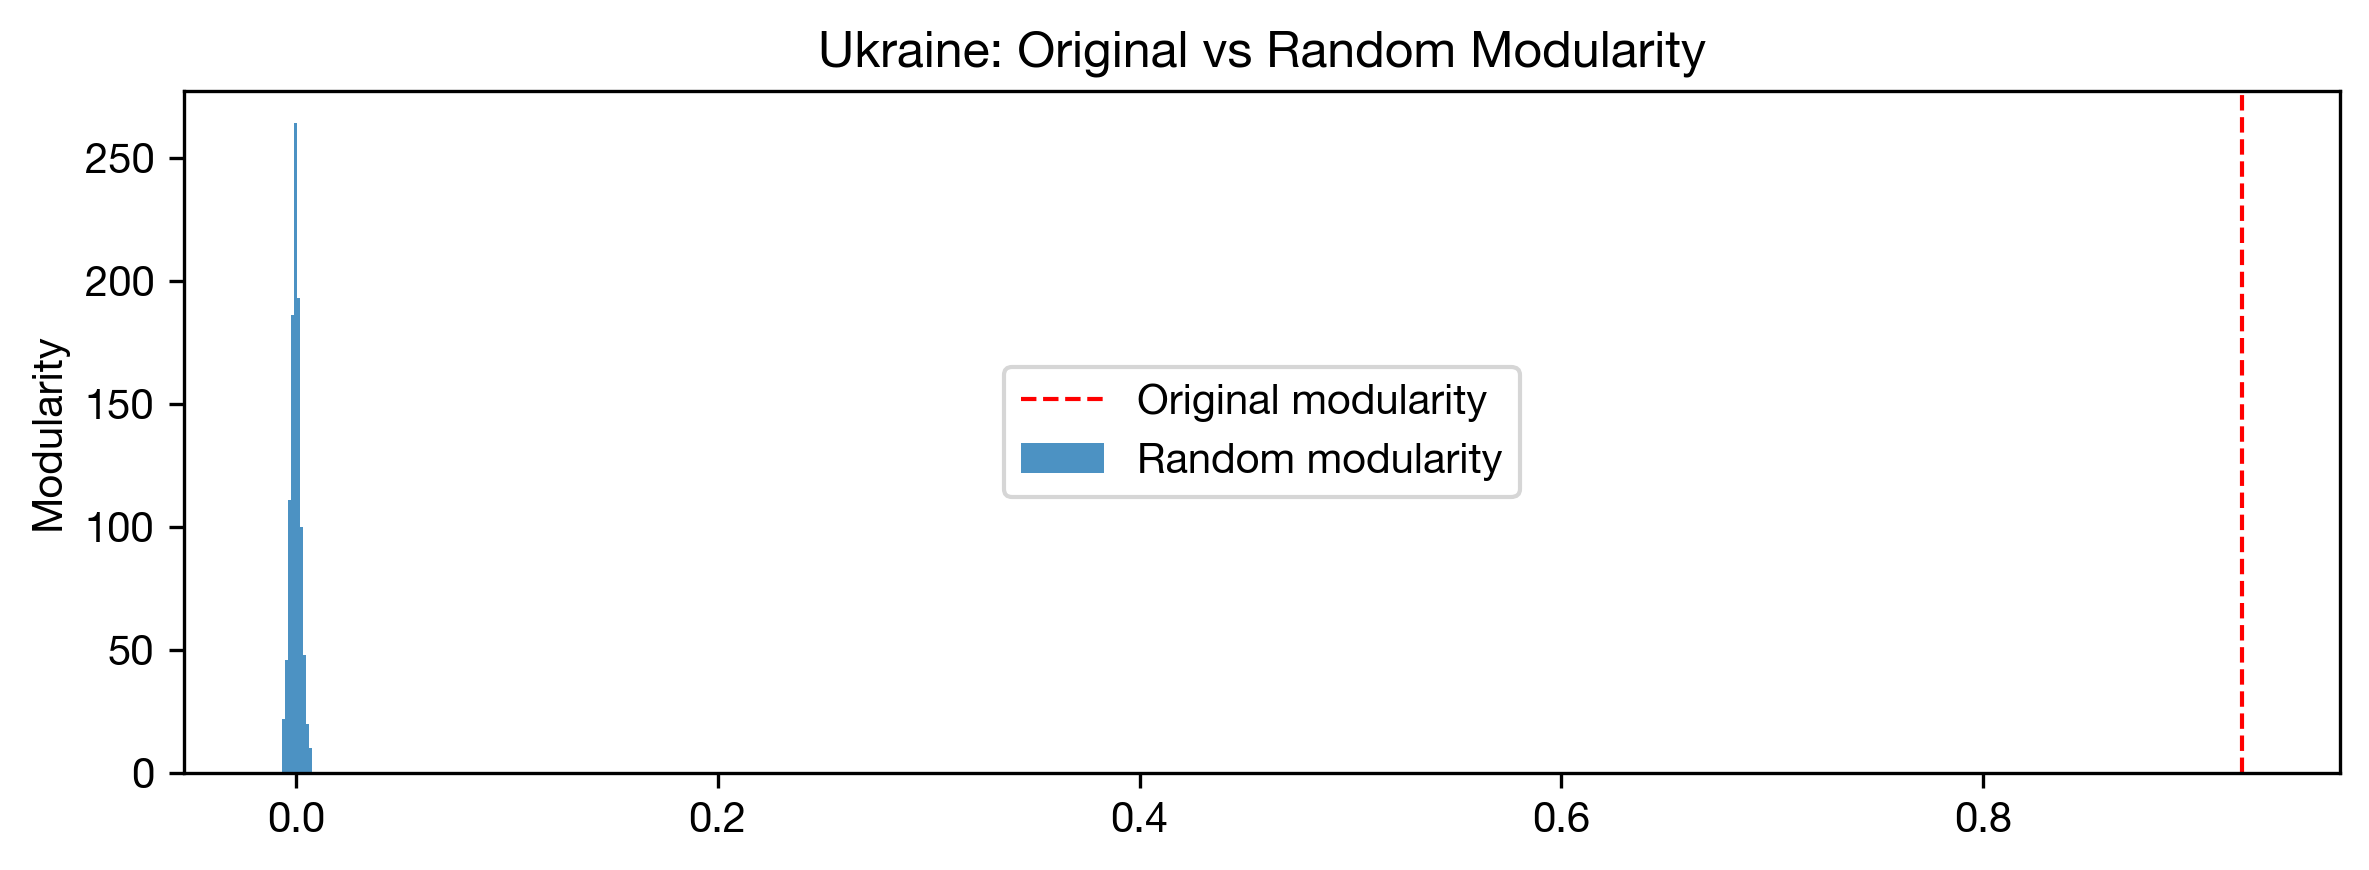

In [170]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(8,3),tight_layout = True)
ax.hist(uk_mods_config1000, label="Random modularity", alpha=0.8)

    
ax.axvline(x=H_uk_mod, label="Original modularity", color="r", ls = "--")
ax.set_ylabel("Modularity")
plt.title("Ukraine: Original vs Random Modularity")
plt.legend(loc=10)
plt.savefig("uk_1000mods.png")
plt.show()

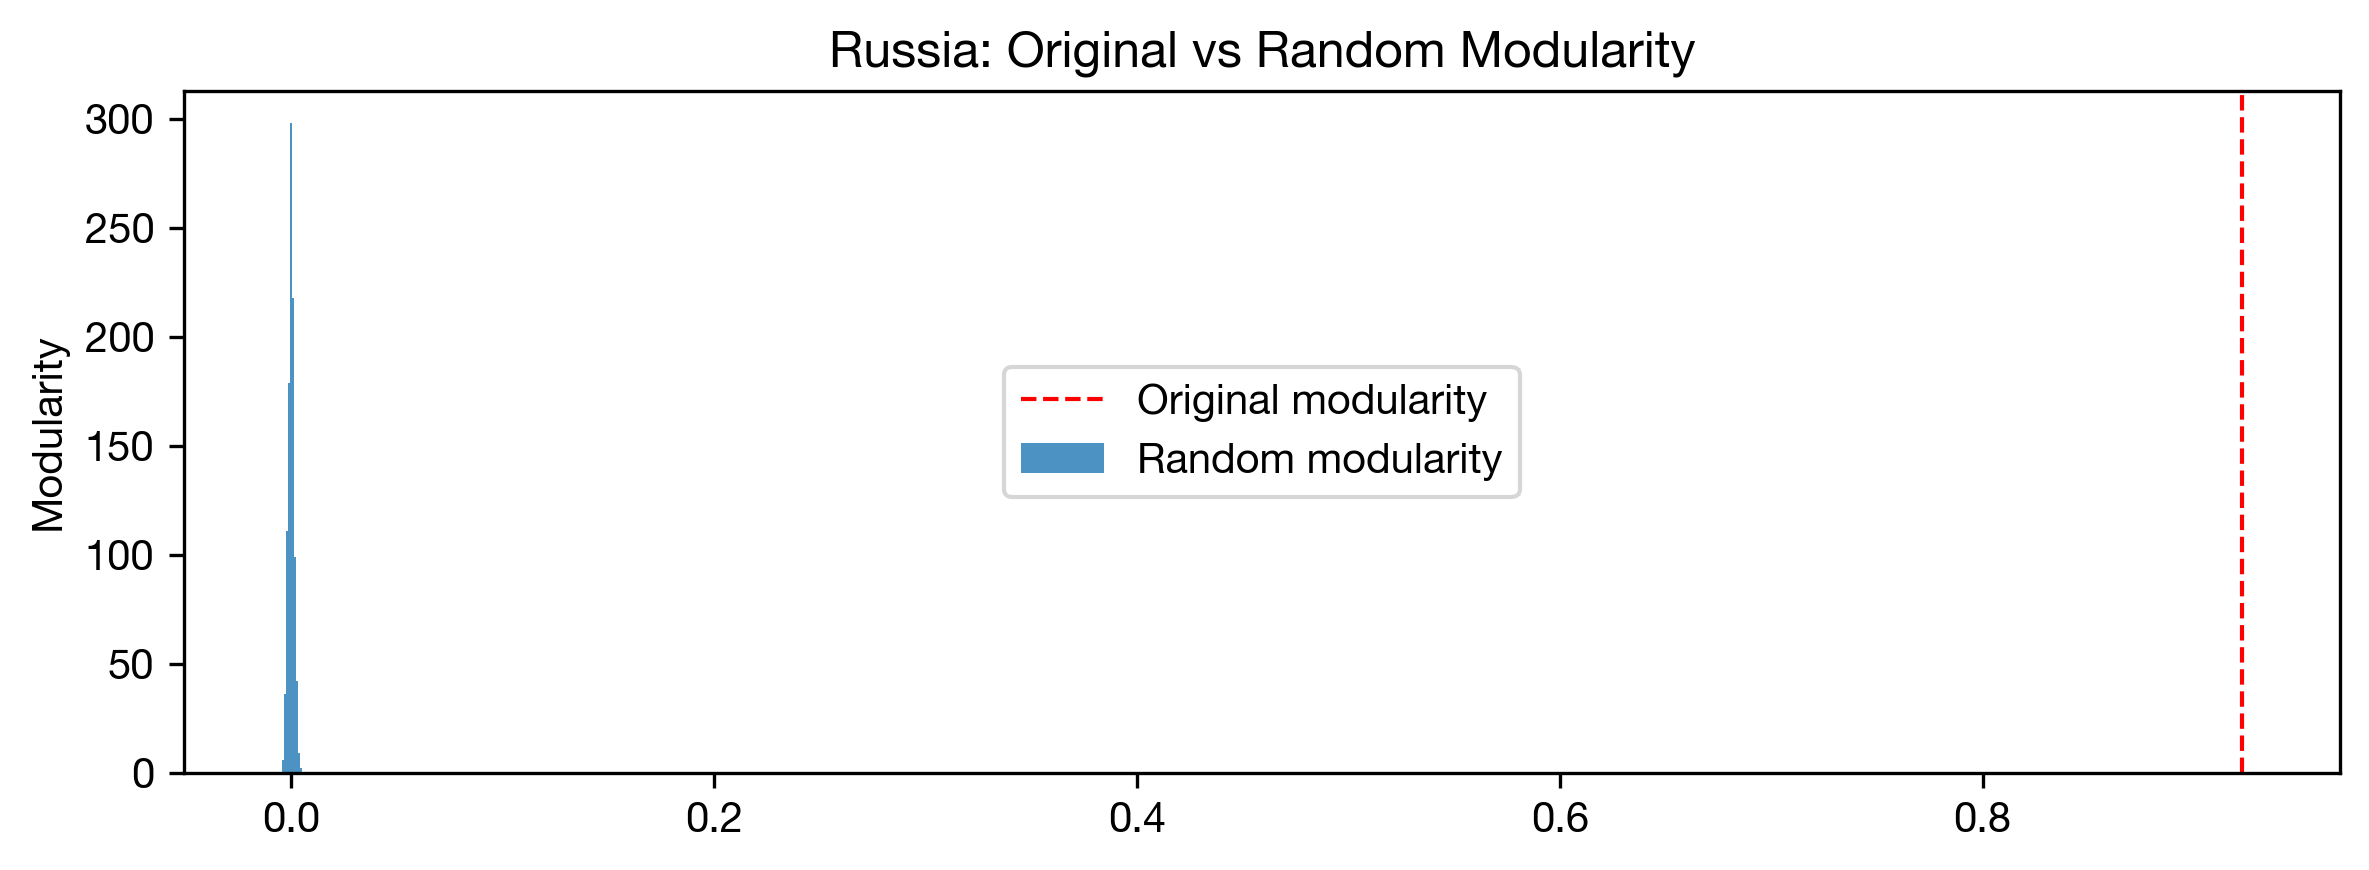

In [171]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(8,3),tight_layout = True)
ax.hist(ru_mods_config1000, label="Random modularity", alpha=0.8)

    
ax.axvline(x=H_uk_mod, label="Original modularity", color="r", ls = "--")
ax.set_ylabel("Modularity")
plt.title("Russia: Original vs Random Modularity")
plt.legend(loc=10)
plt.savefig("ru_1000mods.png")
plt.show()

In [174]:
import nltk
print(f"Number of communities found: {len(set(partition_uk.values()))}", "\n")

part_fd_uk = nltk.FreqDist(partition_uk.values())

print(f"Size of top 5 communities: {part_fd_uk.most_common(5)}", "\n")


Number of communities found: 606 

Size of top 5 communities: [(14, 164), (26, 136), (3, 100), (10, 85), (30, 75)] 



In [175]:
import nltk
print(f"Number of communities found: {len(set(partition_ru.values()))}", "\n")

part_fd_ru = nltk.FreqDist(partition_ru.values())

print(f"Size of top 5 communities: {part_fd_ru.most_common(5)}", "\n")



Number of communities found: 1323 

Size of top 5 communities: [(120, 291), (28, 290), (4, 228), (6, 225), (24, 194)] 



## 4) Interactive Ukrainian and Russian Twitter Networks
Creating interactive graphs based on original tweets and replies in Ukrainian and Russian.

In [ ]:
subset_tweets = all_tweets.sample(100000)

In [107]:
w_edgelist_ru = create_w_edgelist(subset_tweets, "ru")
_, I_ru = create_nx_graph("ru",w_edgelist_ru)

In [106]:
w_edgelist_uk = create_w_edgelist(subset_tweets, "uk")
_, I_uk = create_nx_graph("uk",w_edgelist_uk)

In [108]:
print(nx.info(I_ru),"\n")

print(nx.info(I_uk))

Name: 
Type: Graph
Number of nodes: 1557
Number of edges: 1030
Average degree:   1.3231 

Name: 
Type: Graph
Number of nodes: 583
Number of edges: 374
Average degree:   1.2830


In [109]:
partition_G_ru = community.community_louvain.best_partition(I_ru)
partition_G_uk = community.community_louvain.best_partition(I_uk)

In [110]:
def get_text(username,parent):
    return subset_tweets.loc[(subset_tweets["username"]==username)&
                         (subset_tweets["parent_author"]==parent)].translated_text.values[0]

In [111]:
def w_edgelist_df(language, w_edgelist):
    w_edgelist_df = w_edgelist.to_frame('size')
    w_edgelist_df = w_edgelist_df.reset_index() 
    w_edgelist_df['text'] = w_edgelist_df[['username','parent_author']].apply(lambda x: get_text(*x), axis=1)
    return w_edgelist_df

In [112]:
w_edgelist_df_ru = w_edgelist_df("ru",w_edgelist_ru)
w_edgelist_df_uk = w_edgelist_df("uk",w_edgelist_uk)

In [113]:
def create_interactive_graph(w_edgelist, w_edgelist_df, partition):
    colors = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for i in range(len(set(partition.values())))]
    net = Network(notebook=True)
    net.height = '1000px'
    net.width = '1000px'

    for user in list(w_edgelist_df.username.unique()):
        net.add_nodes([user],
                         title=[w_edgelist_df.loc[w_edgelist_df["username"]==user].text.values[0]],
                        color=[colors[partition[user]] if user in partition.keys() else '#FFFFFF'])

    for parent in list(w_edgelist_df.parent_author.unique()):
        net.add_nodes([parent],
                        color=[colors[partition[parent]] if parent in partition.keys() else '#FFFFFF'])

    for index, value in w_edgelist.items():
        try:
            net.add_edges([(index[0],index[1],value)])
        except:
            continue
    return net

In [ ]:
net_ru = create_interactive_graph(w_edgelist_ru, w_edgelist_df_ru, partition_ru)
net_ru.show('ru_final.html')

In [ ]:
net_uk = create_interactive_graph(w_edgelist_uk, w_edgelist_df_uk, partition_uk)
net_uk.show('uk_final.html')
